In [8]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'

print(os.getcwd())
os.chdir('/home/jelinek/recetox/')

from ml.eval import eval_model
from ml.pipeline import FeitDataPipeline
from tensorflow import keras

from tensorflow.keras.callbacks import ReduceLROnPlateau

from cfg import *

from livelossplot import PlotLossesKerasTF


name = "MySimpleCNN-v2-reduced-atrous-convolution"


/home/jelinek/recetox


In [9]:
from ml.losses import my_sparse_categorical_loss
from ml.util import FeitClasMapGen
from keras import activations




class DeepLabV3(FeitDataPipeline):

    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.model = self.get_compiled_model()
        self.params.name = name
        self.params.epochs = 200
        self.batch_size = 16
        self.params.tile_size=256
        self.params.number_of_classes = 12

        self.data_loader_training = self.get_data_loader_training()
        self.data_loader_validation = self.get_data_loader_validation()

    @staticmethod
    def convolution_block(block_input, num_filters=256, kernel_size=3, dilation_rate=1, padding="same", use_bias=False):
        x = keras.layers.Conv2D(num_filters, kernel_size=kernel_size, dilation_rate=dilation_rate, padding="same",
            use_bias=use_bias, kernel_initializer=keras.initializers.HeNormal())(block_input)
        """
        Function source: https://keras.io/examples/vision/deeplabv3_plus/
        """
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation(activations.relu)(x)
        return x

    @staticmethod
    def DilatedSpatialPyramidPooling(dspp_input):
        """
        Function source: https://keras.io/examples/vision/deeplabv3_plus/
        """

        dims = dspp_input.shape
        x = keras.layers.AveragePooling2D(pool_size=(dims[-3], dims[-2]))(dspp_input)
        x = DeepLabV3.convolution_block(x, kernel_size=1, use_bias=True)
        out_pool = keras.layers.UpSampling2D(
            size=(dims[-3] // x.shape[1], dims[-2] // x.shape[2]), interpolation="bilinear",)(x)

        out_1 = DeepLabV3.convolution_block(dspp_input, kernel_size=1, dilation_rate=1)
        out_6 = DeepLabV3.convolution_block(dspp_input, kernel_size=3, dilation_rate=6)
        out_12 = DeepLabV3.convolution_block(dspp_input, kernel_size=3, dilation_rate=12)
        out_18 = DeepLabV3.convolution_block(dspp_input, kernel_size=3, dilation_rate=18)

        x = keras.layers.Concatenate(axis=-1)([out_pool, out_1, out_6, out_12, out_18])
        output = DeepLabV3.convolution_block(x, kernel_size=1)
        return output


    @staticmethod
    def get_compiled_model():
        image_size = 256
        inputs = keras.Input(shape=(256,256,3))

        ### [First half of the network: downsampling inputs] ###

        # Entry block
        x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)

        previous_block_activation = x  # Set aside residual

        # Blocks 1, 2, 3 are identical apart from the feature depth.
        for filters in [64, 128, 256]:
            x = keras.layers.Activation("relu")(x)
            x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
            x = keras.layers.BatchNormalization()(x)

            x = keras.layers.Activation("relu")(x)
            x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
            x = keras.layers.BatchNormalization()(x)

            x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

            # Project residual
            residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(
                previous_block_activation
            )
            x = keras.layers.add([x, residual])  # Add back residual
            previous_block_activation = x  # Set aside next residual

        ### [Second half of the network: upsampling inputs] ###

        for filters in [256, 128, 64, 32]:
            x = keras.layers.Activation("relu")(x)
            x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
            x = keras.layers.BatchNormalization()(x)

            x = keras.layers.Activation("relu")(x)
            x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
            x = keras.layers.BatchNormalization()(x)

            x = keras.layers.UpSampling2D(2)(x)

            # Project residual
            residual = keras.layers.UpSampling2D(2)(previous_block_activation)
            residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
            x = keras.layers.add([x, residual])  # Add back residual
            previous_block_activation = x  # Set aside next residual

        # Add a per-pixel classification layer
        outputs = keras.layers.Conv2D(11, 3, activation="softmax", padding="same")(x)
    
        # Define the model
        model = keras.Model(inputs, outputs)
        model.summary()
        return model



    def execute_pipeline(self, perform_validation=True, save_model=True, perform_test_segmentation=True):
        data_train = self.data_loader_training
        data_valid = self.data_loader_validation

        self.model.compile(loss='sparse_categorical_crossentropy',
                           optimizer=self.get_optimizer())


        self._train_model(data_train, data_valid)

    def get_optimizer(self):
        return keras.optimizers.Adam(learning_rate=1e-4, clipvalue=1.)

    def get_data_loader_training(self):
        datagen_train = FeitClasMapGen(horizontal_flip=False, vertical_flip=False, samplewise_center=False,
                                           samplewise_std_normalization=True)

        return datagen_train.flow_from_directory(directory=self.params.data_training, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size),
                                                 broadcast=True)

    def get_data_loader_validation(self):
        datagen_valid = FeitClasMapGen(samplewise_center=False, samplewise_std_normalization=True)
        return datagen_valid.flow_from_directory(directory=self.params.data_validation, color_mode='rgb',
                                                 class_mode='categorical', batch_size=self.params.batch_size,
                                                 shuffle=True,
                                                 target_size=(self.params.tile_size, self.params.tile_size),
                                                 broadcast=True)


    def _train_model(self, data_train, data_valid):

        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,
                                      patience=30, min_lr=1e-4, verbose=1,
                                      cooldown=20)

        class_weights = {k : 1.0 for k in range(self.params.number_of_classes)}
        class_weights[self.params.number_of_classes] = 0.0

        self.model.fit(data_train,
                       steps_per_epoch=250,
                       epochs=20,
                       shuffle=True,
                       validation_data=data_valid,
                       validation_freq=100,
                       verbose=1,
                       validation_steps=10000,
                       callbacks=[self.tensorboard, reduce_lr, PlotLossesKerasTF()])

        print("Ahoj")

In [10]:
pipeline = DeepLabV3(train_data_dir='data/Feit_colon-annotation_valid/',
                        valid_data_dir='data/Feit_colon-annotation_valid/')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_9 (Conv2D)              (None, 128, 128, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_15 (BatchN  (None, 128, 128, 32  128        ['conv2d_9[0][0]']               
 ormalization)                  )                                                           

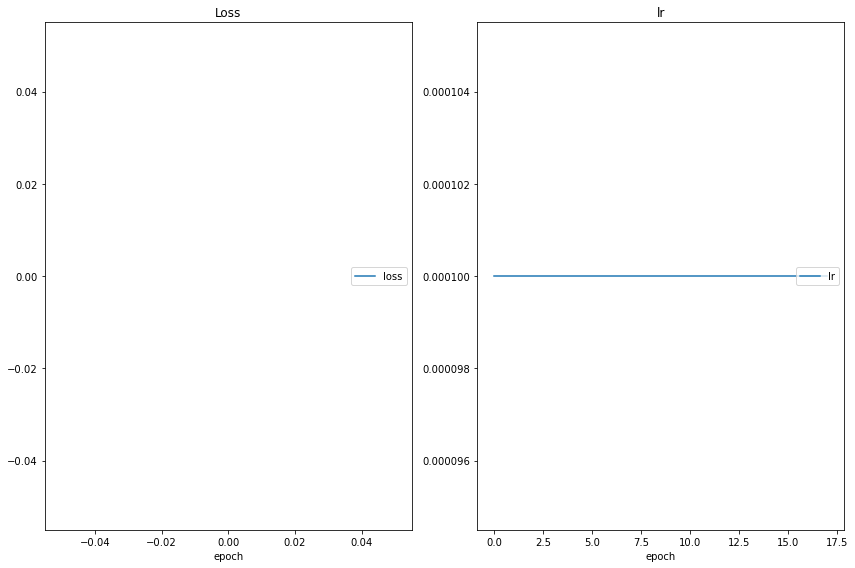

Loss
	loss             	 (min:      nan, max:      nan, cur:      nan)
lr
	lr               	 (min:    0.000, max:    0.000, cur:    0.000)
250/250 [==============================] - 38s 152ms/step - loss: nan - lr: 1.0000e-04
Epoch 19/20
 12/250 [>.............................] - ETA: 35s - loss: nan

KeyboardInterrupt: 

In [11]:
pipeline.execute_pipeline(perform_validation=True, perform_test_segmentation=False)

In [ ]:
pipeline.save_pipeline()

In [ ]:
eval_model(pipeline.model,
           pipeline.get_data_loader_validation(),
           name,
           print_confusion_matrix=True,
           save_misclassified=True)

In [ ]:
pipeline = FeitDataPipeline.load_pipeline(pipeline_name=name)

In [ ]:
from ml.eval import evaluate_segmentation_on_feit_annotation

evaluation_path = Path('data/Feit_colon-annotation_valid/')

segmentation_dir = Path('segmentations') / pipeline.params.name

evaluate_segmentation_on_feit_annotation(evaluation_path, pipeline.build_segmenter(),
                                         32, pipeline.params.class_names,
                                         save_segmentations=True, segmentations_dir=segmentation_dir,
                                         neighbourhood_size=3)